# pattern_recog_func.py

In [7]:
%matplotlib inline
# import warnings
# warnings.filterwarnings("ignore", category=DeprecationWarning)
from scipy.interpolate import interp2d
from skimage import transform, data, io
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.datasets import load_digits
from sklearn import preprocessing
from sklearn import svm
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
from pdb import set_trace

def interpol_im(im, dim1=8, dim2=8, plot_new_im=False, cmap='binary', axis_off=False):
    im = im[:,:,0]
    x = np.arange(im.shape[1])
    y = np.arange(im.shape[0])

    f2d = interp2d(x, y, im)
    
    x_new = np.linspace(0, im.shape[1], dim1)
    y_new = np.linspace(0, im.shape[0], dim2)
    im_new = -f2d(x_new, y_new)
    
    im_flat = im_new.flatten()
    
    if plot_new_im:
        plt.imshow(im_new, cmap=cmap, interpolation='nearest')
        if axis_off:
            plt.grid('off')
        plt.show()
        
    return im_flat

def pca_X(X, n_comp=10):
    md_pca = PCA(n_components=n_comp, whiten=True)
    X_proj = md_pca.fit_transform(X)
    return md_pca, X_proj

def rescale_pixel(X, unseen, ind=0):
    X_train = X[ind]
    min_max_scaler = preprocessing.MinMaxScaler(feature_range=(min(X_train), max(X_train)))
    unseen_scaled = min_max_scaler.fit_transform(X_train.reshape(1, -1), unseen.reshape(1, -1)).astype(int)
    return unseen_scaled
    
def svm_train(X, y, gamma=0.001, C=100):
    # instantiating an SVM classifier
    md_clf = svm.SVC(gamma=0.001, C=100.)

    # apply SVM to training data and draw boundaries.
    md_clf.fit(X, y)
    # a prediction for the test data point.
    return md_clf

def pca_svm_pred(imfile, md_pca, md_clf, dim1=45, dim2=60):
    im = mpimg.imread(imfile)
    im_flat = interpol_im(im, dim1=dim1, dim2=dim2, plot_new_im=True)
    im_flat_proj = md_pca.transform(im_flat.reshape(1, -1))
    pre = md_clf.predict(im_flat_proj.reshape(1, -1))
    return pre

# dig_recog.py

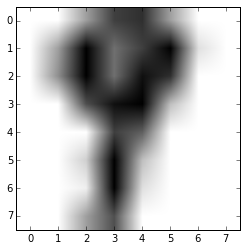

--------> index, actual digit, svm_prediction: 69, 9, 8
Total number of mis-identifications: 0
Success rate: 95.000000


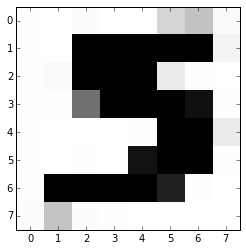

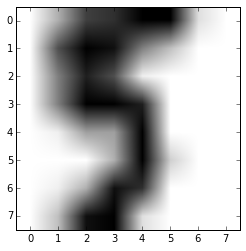

Predictions for unscaled and scaled unseen image: 2, 2


In [8]:
from scipy.interpolate import interp2d
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.datasets import load_digits
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
from skimage import transform, data, io


dig_data = load_digits()
X = dig_data.data
y = dig_data.target

md_clf = svm_train(X[0:60], y[0:60])
perc = 0
mis = 0
tot_start = 60
tot_end = 80
for i in range(tot_start, tot_end):
    ans = y[i]
    pre = md_clf.predict(X[i].reshape(1, -1))[0]
    if ans != pre:
        mis += 1
        plt.imshow(X[i].reshape((8, 8)), cmap='binary')
        plt.show()
        print("--------> index, actual digit, svm_prediction: {:d}, {:d}, {:d}".format(i, ans, pre))
    if ans == pre:
        perc += 1.
        
percentage = (perc/(tot_end-tot_start))*100.
print("Total number of mis-identifications: {:d}".format(mis))
print("Success rate: {:f}".format(percentage))

############################################################################
############################## unseen_dig.png ##############################
############################################################################

unseen = mpimg.imread('unseen_dig.png')
unseen_flat = interpol_im(unseen, plot_new_im=True)

plt.imshow(X[15].reshape((8, 8)), cmap='binary')
plt.show()

unseen_scaled = rescale_pixel(X, unseen_flat, ind=15)

unseen_pre = md_clf.predict(unseen_flat.reshape(1, -1))
unseen_scaled_pre = md_clf.predict(unseen_scaled.reshape(1, -1))
print("Predictions for unscaled and scaled unseen image: {:d}, {:d}".format(unseen_pre[0], unseen_scaled_pre[0]))

# face_recog.py

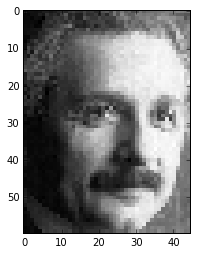

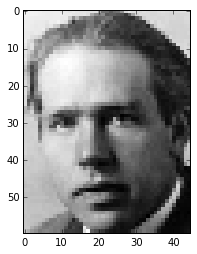

PCA+SVM prediction for physicist 1: Einstein
PCA+SVM prediction for physicist 2: Bohr


In [9]:
bohr = 10
ein = 11
flat_bohr = []
flat_ein = []
y = []
phys_dict = {0: 'Bohr', 1: 'Einstein'}

for i in range(bohr):
    im = mpimg.imread('bohr'+str(i)+'.jpeg')
    flat_bohr.append(interpol_im(im, dim1=45, dim2=60, plot_new_im=False, cmap='binary', axis_off=True))
    y.append(0)
for i in range(ein):
    im = mpimg.imread('ein'+str(i)+'.jpeg')
    flat_ein.append(interpol_im(im, dim1=45, dim2=60, plot_new_im=False, cmap='binary', axis_off=True))
    y.append(1)
    
X = np.vstack((np.array(flat_bohr), np.array(flat_ein)))

md_pca, X_proj = pca_X(X)

perc = 0
tot = 21

for select_idx in range(tot):
#     set_trace()
    Xtrain = np.delete(X, select_idx, axis = 0)
    ytrain = np.delete(y, select_idx)
    
    md_pca.fit(Xtrain)
    Xtrain_proj = md_pca.transform(Xtrain)

    Xtest = X[select_idx].reshape(1, -1)
    ytest = y[select_idx]
    Xtest_proj = md_pca.transform(Xtest)

    md_clf = svm_train(Xtrain_proj, ytrain)
    pre = md_clf.predict(Xtest_proj)
    if pre == ytest:
        perc += 1.
        
perc /= (tot/100.)

unseen_phys1 = 'unseen_phys1.jpg'
unseen_phys2 = 'unseen_phys2.jpg'

pre1 = pca_svm_pred(unseen_phys1, md_pca, md_clf)
pre2 = pca_svm_pred(unseen_phys2, md_pca, md_clf)

pre_ein_statement = 'PCA+SVM prediction for physicist 1: {:s}'.format(phys_dict[pre1[0]])
pre_bohr_statement = 'PCA+SVM prediction for physicist 2: {:s}'.format(phys_dict[pre2[0]])

print(pre_ein_statement)
print(pre_bohr_statement)